# 3rd Place Solution Part: BestGuess + Optimizer


Main architecture:
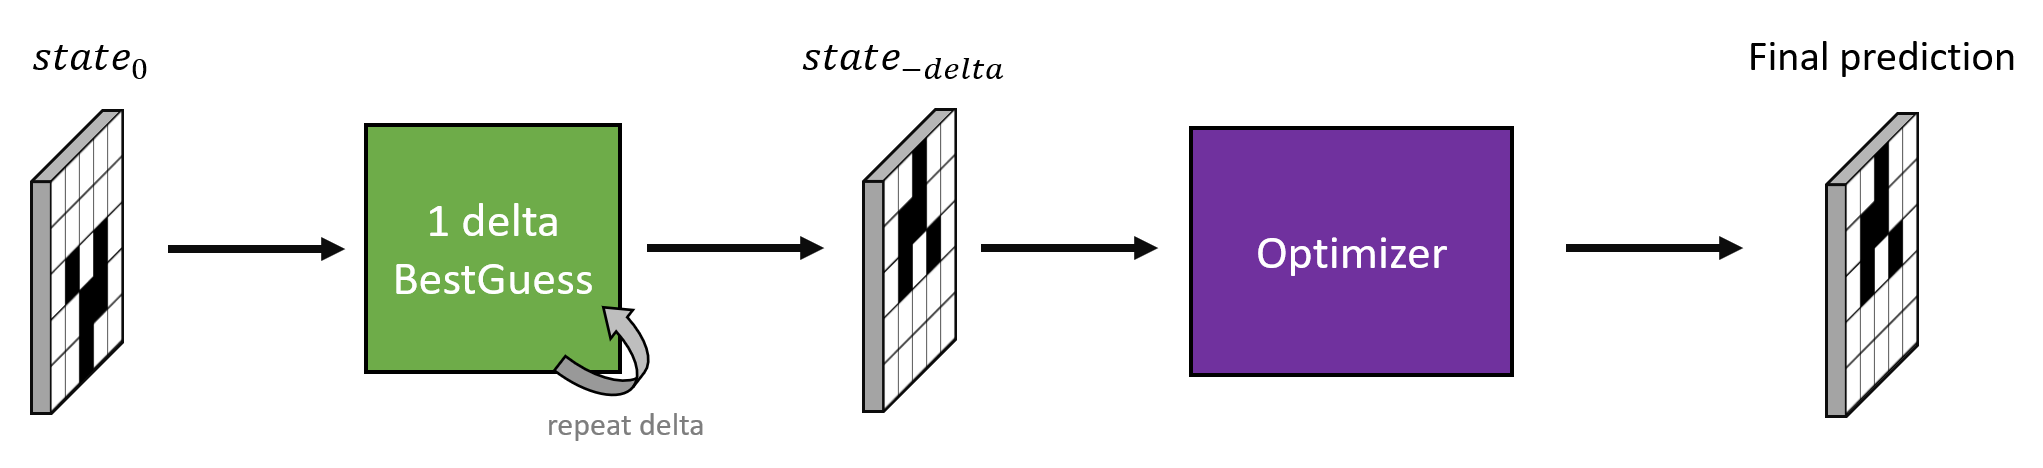



Hi all,

thanks for the really interesting competition. I quickly want to share my solution. It is split up into 2 main blocks:
* **BestGuess**, which is an iterative neural network approach. It predicts the start state for delta=1. Repeating it delta times for delta>1
* And an **Optimizer**, which picks a random 3x3 reagion in the input, tries every possible combination of the 3x3 grid at once and selects randomly between the ones which produce the lowest score. It is entirely implemented on the GPU.


This approach reached a score of 0.018 before merging. 


## 1 delta BestGuess
Architecture:
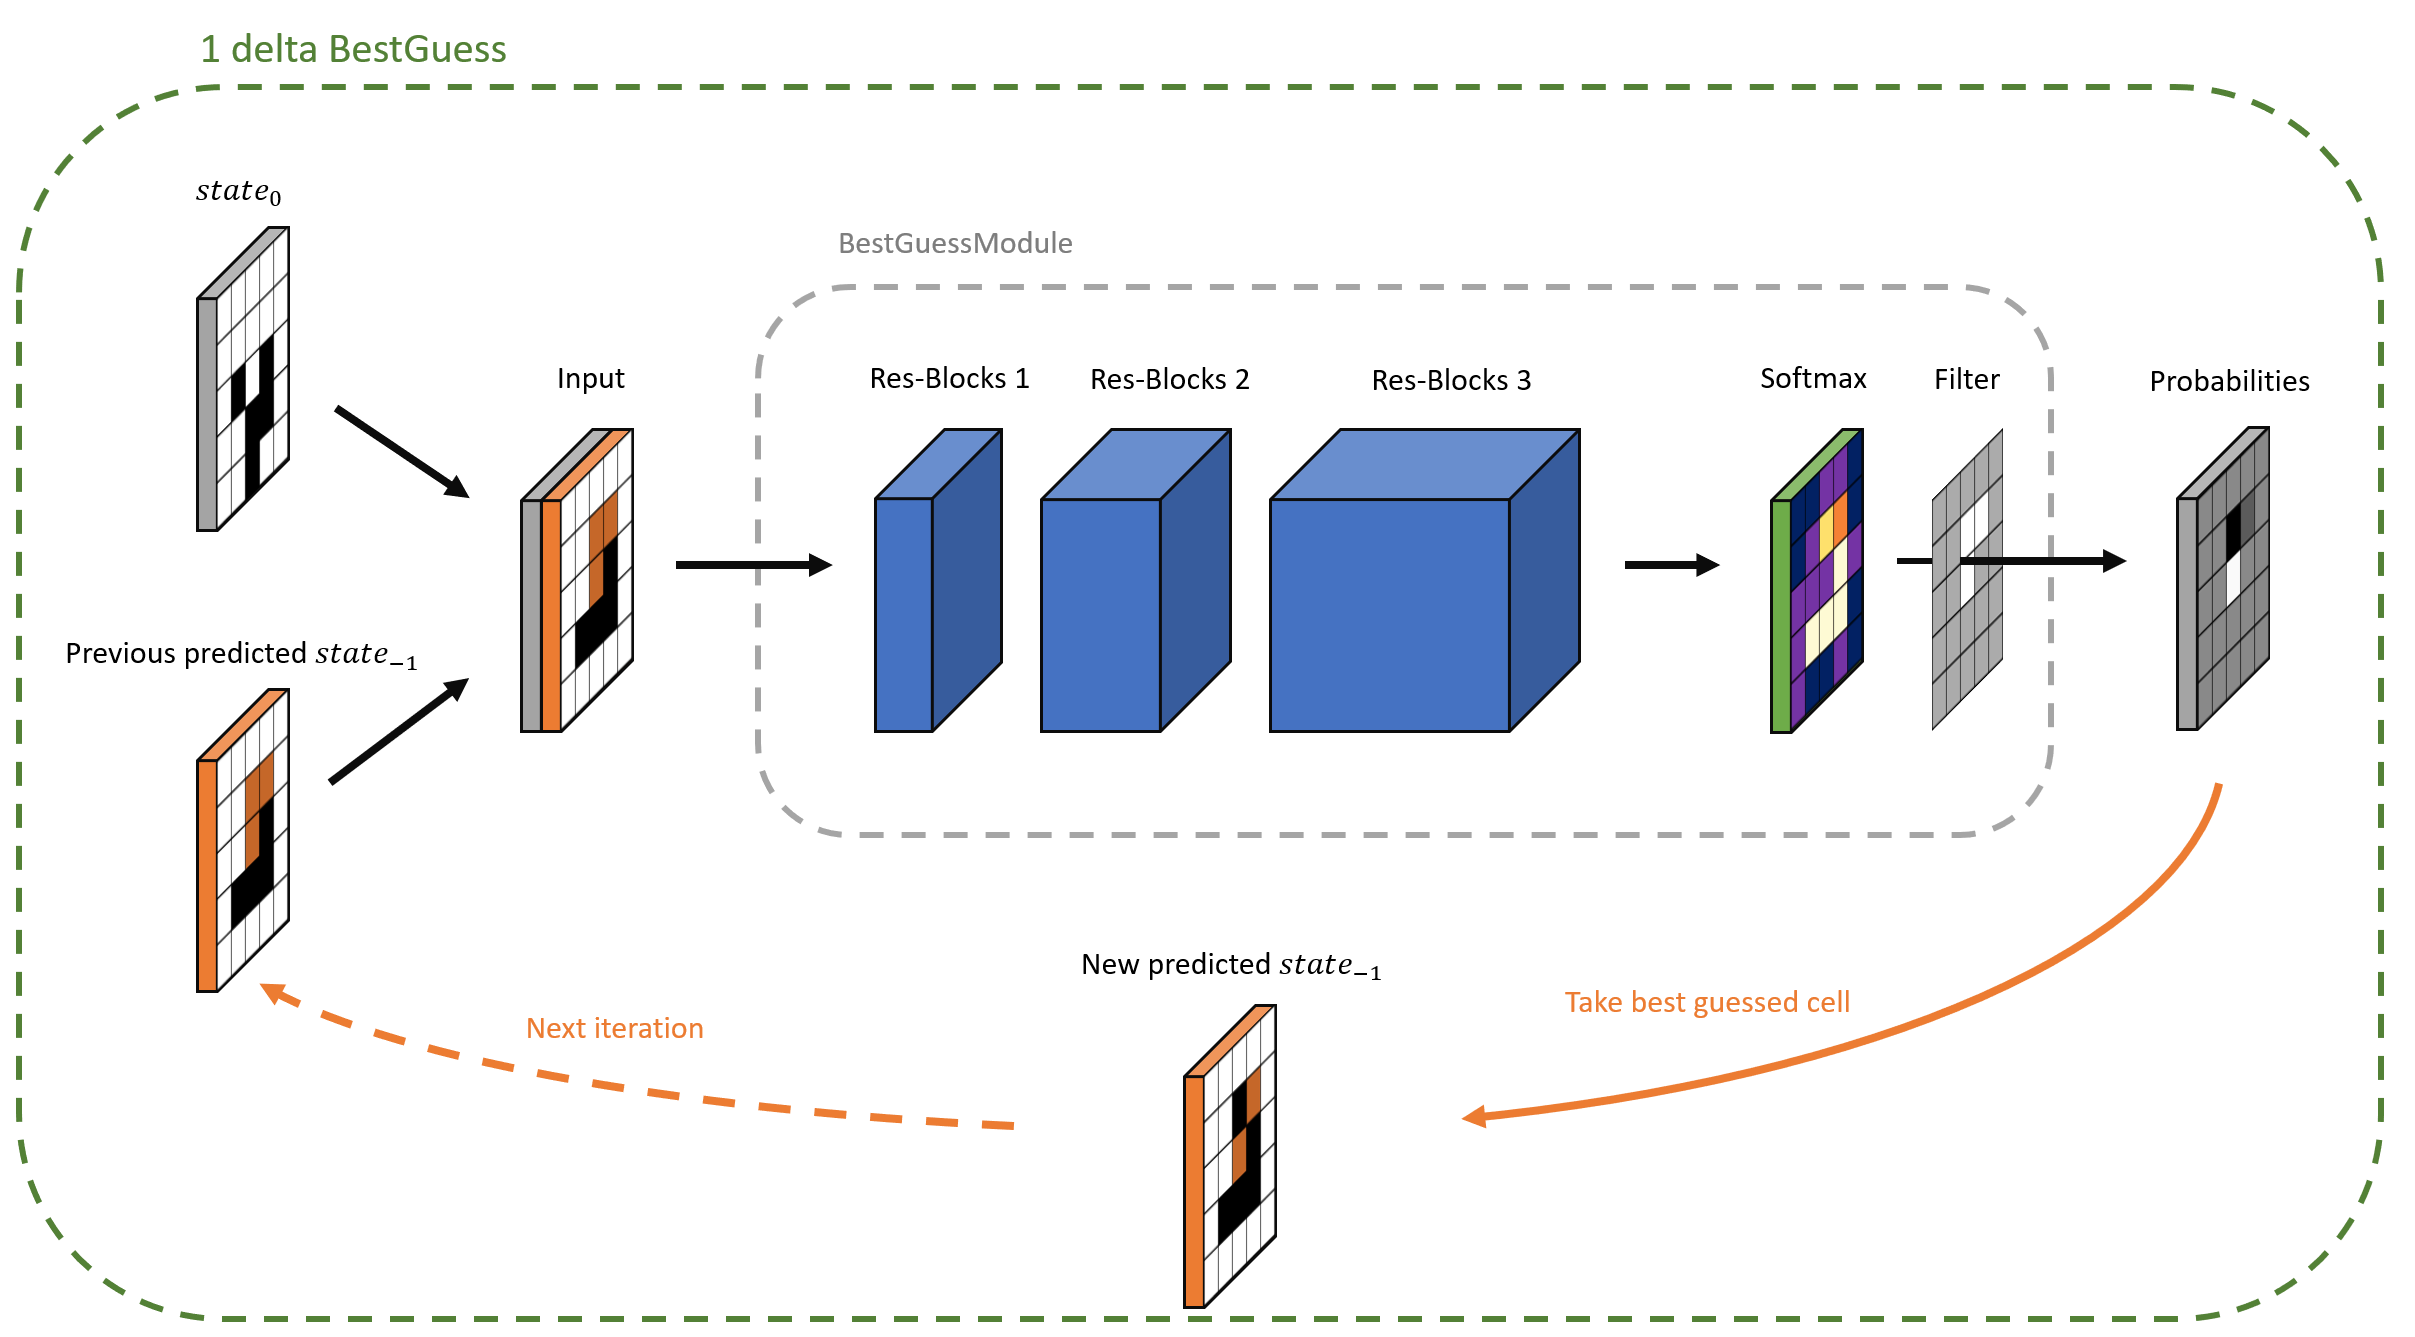

The network only predicts one cell at a time, because there are many possible start states which lead to the same end state. By giving the network its previous prediction, it is enough to just estimate which cells are more likely to be alive or dead. While at the beginning the prediction might be very uncertain, by adding more and more predicted cells, the possible start state combinations narrow down and the network gets more certain.

Training is done supervised by just marking random cells in an end state as unpredicted and setting the start state as target.

Here is a visualization of the solving process:

In [ ]:
import gc

import pandas as pd
import math

import cv2
import numpy as np
import matplotlib
import random

from tensorboard.backend.event_processing import event_accumulator
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import os

import torch.nn.functional as F

from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:



def state_step(state: np.array):
    neighbour_sum = \
        np.roll(state, -1, axis=0) + \
        np.roll(state, 1, axis=0) + \
        np.roll(state, -1, axis=1) + \
        np.roll(state, 1, axis=1) + \
        np.roll(np.roll(state, -1, axis=0), -1, axis=1) + \
        np.roll(np.roll(state, -1, axis=0), 1, axis=1) + \
        np.roll(np.roll(state, 1, axis=0), -1, axis=1) + \
        np.roll(np.roll(state, 1, axis=0), 1, axis=1)
    out = np.zeros(state.shape, dtype=np.int)
    out[neighbour_sum == 3] = 1
    out[np.logical_and(neighbour_sum == 2, state == 1)] = 1
    return out


class TiledConv2d(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features, kernel_size=3, bias=False)

    def forward(self, x):
        return self.conv(F.pad(x, [1, 1, 1, 1], mode='circular'))


class TiledResBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.main = nn.Sequential(
            nn.BatchNorm2d(features),
            nn.ReLU(True),
            TiledConv2d(features, features),
            nn.BatchNorm2d(features),
            nn.ReLU(True),
            TiledConv2d(features, features)
        )

    def forward(self, x):
        return self.main(x) + x


def best_guess_block(input_channels, channels):
    return nn.Sequential(
        nn.Conv2d(input_channels, channels, 1, bias=False),
        TiledResBlock(channels),
        TiledResBlock(channels),
        nn.BatchNorm2d(channels),
        nn.ReLU(True),
    )


def create_net_input_array(state: np.array, predicted_mask: np.array, predictions: np.array):
    input_dead = (1 - state).astype(np.float)
    input_alive = state.astype(np.float)
    input_unpredicted = (1 - predicted_mask).astype(np.float)
    input_predicted_dead = ((1 - predictions) * predicted_mask).astype(np.float)
    input_predicted_alive = (predictions * predicted_mask).astype(np.float)
    sample_input = np.stack([
        input_dead,
        input_alive,
        input_unpredicted,
        input_predicted_dead,
        input_predicted_alive],
        axis=2
    )

    return sample_input.transpose((2, 0, 1)).astype(np.float)


class BestGuessModule(nn.Module):
    def __init__(self, channels=16 * 8):
        super().__init__()

        self.main = nn.Sequential(
            best_guess_block(5, channels),
            best_guess_block(channels, channels * 2),
            best_guess_block(channels * 2, channels * 4),
            nn.Conv2d(channels * 4, 2, 1)
        )

    def forward(self, x):
        return self.main(x)

    def get_probabilities(self, x):
        return torch.softmax(self.main(x), 1)

    def get_best_guess(self, x: torch.tensor, mask: np.array):
        probabilities = self.get_probabilities(x)
        masked_probabilities = np.array(probabilities.tolist()) * (1 - mask)
        guess = np.unravel_index(masked_probabilities.argmax(), masked_probabilities.shape)
        return {
            "coord_yx": np.array([guess[2], guess[3]]),
            "alive": guess[1]
        }

    def get_best_guesses(self, x: torch.tensor, mask: np.array, num_guesses=2):
        probabilities = self.get_probabilities(x)
        masked_probabilities = np.array(probabilities.tolist()) * (1 - mask)
        guess = np.unravel_index(masked_probabilities.argmax(), masked_probabilities.shape)
        return {
            "coord_yx": np.array([guess[2], guess[3]]),
            "alive": guess[1]
        }

    def get_best_by_threshold(self, x: torch.tensor, mask: np.array, threshold: float):
        probabilities = self.get_probabilities(x)
        masked_probabilities = np.array(probabilities.tolist()) * (1 - mask)
        results = np.where(masked_probabilities >= threshold)
        return {
            "coord_yx": np.array([results[2], results[3]]),
            "alive": results[1]
        }

    def get_tendencies_img(self, x):
        return np.array(self.get_probabilities(x).tolist()).transpose((0, 2, 3, 1))[0, :, :, 1]


    def solve(self,
              state: np.array,
              device: torch.device,
              ground_truth=None):

        predicted_mask = np.zeros(state.shape)
        predictions = np.zeros(state.shape)
        total_runs = state.shape[0] * state.shape[1]
        
        fig = plt.figure(figsize=(8, 6))

        def animate(i):
            sample_input = create_net_input_array(state, predicted_mask, predictions)
            batch_input = torch.from_numpy(np.expand_dims(sample_input, 0)).float().to(device)
            guess = self.get_best_guess(batch_input, predicted_mask)
            predicted_mask[guess['coord_yx'][0], guess['coord_yx'][1]] = 1
            predictions[guess['coord_yx'][0], guess['coord_yx'][1]] = guess['alive']


            # input
            plt.clf()
            sub = fig.add_subplot(2, 3, 1)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("start (ground truth)")
            if ground_truth is not None:
                sub.imshow(ground_truth.astype(np.float))
            sub = fig.add_subplot(2, 3, 4)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("end state")
            sub.imshow(state.astype(np.float))

            # net
            sub = fig.add_subplot(2, 3, 3)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("net probabilities")
            prob = self.get_tendencies_img(batch_input)
            overlay = np.ones((state.shape[0], state.shape[1], 4), dtype=np.float)
            overlay[:, :, 3] = predicted_mask
            # prob[prob < 0.5] *= -1
            # prob[prob < 0.5] += 1.0
            # prob *= (1 - prev_predicted_mask)
            sub.imshow(prob, vmin=0.0, vmax=1.0)
            sub.imshow(overlay, vmin=0.0, vmax=1.0)

            # outcome
            sub = fig.add_subplot(2, 3, 2)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("net prediction")
            overlay = np.ones((state.shape[0], state.shape[1], 4), dtype=np.float)
            overlay[:, :, 3] = (1.0 - predicted_mask) * 0.66
            sub.imshow(predictions.astype(np.float))
            sub.imshow(overlay, vmin=0.0, vmax=1.0)
            sub = fig.add_subplot(2, 3, 5)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("forwarded prediction".format(1))
            outc = predictions
            for d in range(1):
                outc = state_step(outc)
            overlay = np.zeros((state.shape[0], state.shape[1], 4), dtype=np.float)
            overlay[outc - state != 0] = [1, 0.2, 0.2, 1]
            sub.imshow(outc.astype(np.float))
            sub.imshow(overlay, vmin=0.0, vmax=1.0)

        anim = animation.FuncAnimation(fig, animate, frames=total_runs, interval=50)
        plt.clf()
        return predictions, anim

    
device = torch.device('cuda')
bestGuess = BestGuessModule()
bestGuess.load_state_dict(torch.load('../input/gol-pretrained-model/epoch_040.pt'))
bestGuess.to(device)
bestGuess.eval()


In [ ]:
# feel free to enter your own end state here
end_state = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]])

# this may take a while to calculate with the animation...
pred_start_state, anim = bestGuess.solve(end_state, device)
HTML(anim.to_jshtml())

It can be seen how it starts with simple cells and solves the more difficult ones at the end.
Some things I noticed:
* It reconstrcuts the glider (middle left) correctly
* Because it is trained to learn the distribution of given GoL states, it generates more "game of life looking" patterns.
* It starts solving (is most certain) around simple patterns. Before filling empty space. This could be, because in the empty areas the probability that some structure died in the start state is higher than arround a well known pattern. 

I also tried training the network to predict delta>1 directy but it seemed to require a huge ammount of time and way more parameters. This model has alread 12 mio. parameters, which was enough for my gtx 980 ti.

Sadly, the error increases a lot when repeating the guessing algorithm for delta>1. While at delta=1 its average loss is about 0.002. With delta=2 it increased ten times to 0.017. For delta=3 already 0.11.

## Optimizer


The optimizer improves the input state by randomly selecting 3 by 3 regions and testinal all possible inputs for this region. It then takes only the solutions which generate the lowest score. If there are multiple solutions with the same score, it will select randomly one of them. This process gets repeated multiple times.

Below is an example with delta=3 where first BestGuess is applied 3 times and then the optimizer at the end.

In [ ]:
def binary_clamp(x: torch.tensor):
    return torch.clamp(x, 0, 1)


def conway_layer(x: torch.tensor):
    surround_sum = torch.roll(x, 1, 2) + torch.roll(x, -1, 2) + torch.roll(x, 1, 3) + torch.roll(x, -1, 3) +\
        torch.roll(x, (-1, -1), (2, 3)) + torch.roll(x, (1, -1), (2, 3)) + torch.roll(x, (-1, 1), (2, 3)) + torch.roll(x, (1, 1), (2, 3))
    return binary_clamp(surround_sum + x - 2) - binary_clamp(surround_sum - 3)


class TilePad2d(nn.Module):
    def __init__(self, left, right, top, bottom):
        super().__init__()
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom

    def forward(self, x):
        return F.pad(x, [self.left, self.right, self.top, self.bottom], mode='circular')


class BestChangeLayer(nn.Module):
    def __init__(self, delta=1, window=(3, 3), device=torch.device('cpu')):
        super().__init__()
        self.device = device
        self.window = window
        self.influence_window = (window[0] + 4 * delta, window[1] + 4 * delta)
        self.delta = delta
        self.num_bins = window[0] * window[1]
        self.num_possible_window_inputs = 2 ** self.num_bins
        self.possible_inputs = np.zeros((self.num_possible_window_inputs, self.num_bins))

        # compute all possible
        for i in range(self.num_possible_window_inputs):
            self.possible_inputs[i] = np.array(list(np.binary_repr(i, self.num_bins)), dtype=np.float)
        self.possible_inputs = self.possible_inputs.reshape((1, self.num_possible_window_inputs, window[0], window[1]))

        self.possible_inputs_mask = np.zeros((1, self.num_possible_window_inputs, self.influence_window[0], self.influence_window[1]), dtype=np.float)
        self.possible_inputs_mask[:, :, 2*delta:-2*delta, 2*delta:-2*delta] = 1
        self.possible_inputs_window = np.zeros((1, self.num_possible_window_inputs, self.influence_window[0], self.influence_window[1]), dtype=np.float)
        self.possible_inputs_window[:, :, 2 * delta:-2 * delta, 2 * delta:-2 * delta] = self.possible_inputs

        self.pi = torch.from_numpy(self.possible_inputs).float().to(device)
        self.pi_window = torch.from_numpy(self.possible_inputs_window).float().to(device)
        self.pi_window_mask = torch.from_numpy(self.possible_inputs_mask).float().to(device)
        self.pi_window_inv_mask = -self.pi_window_mask + 1

        self.replication_input_layer = TilePad2d(
            delta * 2,
            delta * 2 + window[1] - 1,
            delta * 2,
            delta * 2 + window[0] - 1)

        self.replication_target_layer = TilePad2d(
            delta,
            delta + window[1] - 1,
            delta,
            delta + window[0] - 1)

        self.unpool = nn.MaxUnpool1d(self.num_possible_window_inputs)

    def forward(self, x: torch.Tensor, target: torch.Tensor):

        random_x = np.random.randint(0, x.size()[3])
        random_y = np.random.randint(0, x.size()[2])

        influence_window = self.replication_input_layer(x)[:, :, random_y:(random_y + self.influence_window[0]), random_x:(random_x + self.influence_window[1])]
        target_window = self.replication_target_layer(target)[:, :, random_y:(random_y + self.window[0] + 2 * self.delta), random_x:(random_x + self.window[1] + 2 * self.delta)]
        process_window = influence_window.repeat(1, self.num_possible_window_inputs, 1, 1)
        process_window = process_window * self.pi_window_inv_mask + self.pi_window
        end = process_window
        for d in range(self.delta):
            end = conway_layer(end)[:, :, 1:-1, 1:-1]

        errors = torch.sum(torch.abs(end - target_window.repeat(1, self.num_possible_window_inputs, 1, 1)), (2, 3))
        seeded_errors = errors + torch.rand(errors.size(), device=self.device) * 0.5

        indices = torch.argmin(seeded_errors, 1)
        best_mask = self.unpool(torch.ones((seeded_errors.size()[0], 1, 1), device=self.device), indices.reshape(-1, 1, 1)).reshape(-1, self.num_possible_window_inputs, 1, 1)
        best_inputs = torch.sum(self.pi * best_mask, 1).reshape((-1, 1, self.window[0], self.window[1]))

        out = torch.roll(x, shifts=(-random_y, -random_x), dims=(2, 3))
        out[:, :, :self.window[0], :self.window[1]] = best_inputs
        out = torch.roll(out, shifts=(random_y, random_x), dims=(2, 3))

        return out

    def solve(self, initial_state: np.array, target: np.array, device: torch.device, num_steps=1000):
        self.inputs_batch = torch.from_numpy(initial_state).reshape(1, 1, initial_state.shape[0], initial_state.shape[1]).float().to(device)
        self.targets_batch = torch.from_numpy(target).reshape(1, 1, target.shape[0], target.shape[1]).float().to(device)
        
        fig = plt.figure(figsize=(8, 6))
        
        def animate(i):
            self.inputs_batch = self(self.inputs_batch, self.targets_batch)
            state = np.clip(np.rint(np.array(self.inputs_batch.tolist())).astype(np.int), 0, 1).reshape(initial_state.shape)
            
            # input
            plt.clf()
            sub = fig.add_subplot(2, 2, 3)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("target state")
            sub.imshow(target.astype(np.float))

            # outcome
            sub = fig.add_subplot(2, 2, 2)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("optimized pred.")
            sub.imshow(state.astype(np.float))
            sub = fig.add_subplot(2, 2, 4)
            plt.xticks([])
            plt.yticks([])
            sub.set_title("forwarded prediction".format(1))
            outc = state
            for d in range(self.delta):
                outc = state_step(outc)
            overlay = np.zeros((state.shape[0], state.shape[1], 4), dtype=np.float)
            overlay[outc - target != 0] = [1, 0.2, 0.2, 1]
            sub.imshow(outc.astype(np.float))
            sub.imshow(overlay, vmin=0.0, vmax=1.0)
            
        anim = animation.FuncAnimation(fig, animate, frames=num_steps, interval=10)
        plt.clf()
        state = np.clip(np.rint(np.array(self.inputs_batch.tolist())).astype(np.int), 0, 1).reshape(initial_state.shape)
        return state, anim
    
optimizer = BestChangeLayer(delta=3, device=device)

In [ ]:
# feel freee to enter your own end state here
end_state = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]])
current_prediction = end_state.copy()

Predict delta=1:

In [ ]:
current_prediction, anim = bestGuess.solve(current_prediction, device)
HTML(anim.to_jshtml())

Predict from delta=1 to delta=2:

In [ ]:
current_prediction, anim = bestGuess.solve(current_prediction, device)
HTML(anim.to_jshtml())

Predict from delta=2 to delta=3:

In [ ]:
current_prediction, anim = bestGuess.solve(current_prediction, device)
HTML(anim.to_jshtml())

Optimize the prediction with 2000 iterations:

In [ ]:
optimized_start_state, anim = optimizer.solve(current_prediction, end_state, device, 2000)
HTML(anim.to_jshtml())

Thanks for reading and have a nice day!